##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [50]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [105]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [106]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [101]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [95]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [96]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


#Answer

In [ ]:
df[:5]

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [ ]:
ac_set = set()
for ac in df['Area_Command']:
  ac_set.add(ac)

In [ ]:
code_set = set()
for code in df['NIBRSOffenseCode']:
  code_set.add(code)

In [ ]:
dow_set = set()
for dow in df['DayOfWeek']:
  dow_set.add(dow)

In [ ]:
time_set = set()
for time in df['Time']:
  time_set.add(time)

In [ ]:
vc_set = set()
for vc in df['VictimCount']:
  vc_set.add(vc)

In [ ]:
print(
f"All area commands: {ac_set}\nAll Offense Code: {code_set}\nAll day of week: {dow_set}\nAll time code: {time_set}\nALl Victim Count: {vc_set}"
)

All area commands: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
All Offense Code: {0, 1, 2}
All day of week: {0, 1, 2, 3, 4, 5, 6}
All time code: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
ALl Victim Count: {0, 1, 2, 3, 4, 5, 6}


#Explaination of Each Column



1.   X: Denotes the Longitude (Location Co-ordinate)
2.   Y: Denotes the Latitude (Location Co-ordinate)
3.   Area Command: Area Command makes it clear that, this data has 11 different locations under consideration. This is different from Latitude and Longitude which gives exact co-ordinate but rather has range of co-ordinates
4.   NIBRSOffenceCode: This is a classification code of the commited offence.
5.   DayOfWeek: Denotes the 7 days of the week, thus the observed range between [0, 6].
6. Time: This denotes the hour of the day when the crime was reported, thus it has 24 values having a range of [0. 23].
7. VictimCount: Number of victims involved in the accident.


#Input and Target Variables

**X, Y,	Area_Command,	NIBRSOffenseCode,	DayOfWeek, Time** are input variables.

**VictimCount** is the target variable.

#Range of Values


1.   Area_Command: 0 to 11
2.   NIBRSOffenseCode: 0 to 2
3.   DayOfWeek: 0 to 6
4.   Time: 0 to 23
5.   VictimCount: 0 to 6



## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

#Answer

In [ ]:
X = df.drop(columns='VictimCount')
y = df['VictimCount']

In [ ]:
X

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time
0,-115.087518,36.216702,0,0,0,0
1,-115.240172,36.189693,1,1,1,1
2,-115.143088,36.181329,2,1,2,0
3,-115.225014,36.117633,3,1,1,2
4,-115.176708,36.095967,4,1,1,3
...,...,...,...,...,...,...
270,-115.114739,36.119592,5,1,5,18
271,-115.080764,36.162648,0,1,5,17
272,-115.172073,36.123012,4,1,1,16
273,-115.152593,36.066073,5,1,6,23


In [ ]:
y

0      0
1      0
2      1
3      2
4      0
      ..
270    0
271    0
272    2
273    0
274    1
Name: VictimCount, Length: 275, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import torch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
for batch_x, batch_y in train_loader:
    print(batch_x.shape, batch_y.shape)
    break

torch.Size([32, 6]) torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

#Answer

The predicted value will be a single scalar instance as the the output layer of the model has dimension of 1.

I'll be going forward with 3 fully connected layers, where first 2 layers having relu. Since, the problem I am trying to solve is a regression problem I have not added any activation function on the last layer to get raw output.

Adam is a widely used optimizer combining properties of RMSProp and AdaGrad optimizers.

The learning rate is 0.1. What I have observed is that which such a small data high learning rate is a better choice. Starting from 0.001, the best MSE I received was at 0.1.

In [88]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [89]:
input_dim = X_train_tensor.shape[1]
model = RegressionModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader)}")
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for batch_data, batch_labels in test_loader:
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item()
        print(f"Test Loss: {test_loss/len(test_loader)}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch 1/100, Train Loss: 39226.499120371685
Test Loss: 46.3722038269043
Epoch 2/100, Train Loss: 12.083731872694832
Test Loss: 2.3299143314361572
Epoch 3/100, Train Loss: 1.6806905610220773
Test Loss: 1.0377813577651978
Epoch 4/100, Train Loss: 1.1121104444776262
Test Loss: 0.990916520357132
Epoch 5/100, Train Loss: 1.0209091220583235
Test Loss: 0.9125141203403473
Epoch 6/100, Train Loss: 0.9724211437361581
Test Loss: 0.913015604019165
Epoch 7/100, Train Loss: 0.9511924002851758
Test Loss: 0.9127041101455688
Epoch 8/100, Train Loss: 0.9684167504310608
Test Loss: 0.9184569418430328
Epoch 9/100, Train Loss: 0.9524972864559719
Test Loss: 0.9216876327991486
Epoch 10/100, Train Loss: 1.0017299566950117
Test Loss: 0.920708566904068
Epoch 11/100, Train Loss: 0.9814367549760001
Test Loss: 0.91360804438591
Epoch 12/100, Train Loss: 0.9533815043313163
Test Loss: 0.9136474430561066
Epoch 13/100, Train Loss: 0.9651540517807007
Test Loss: 0.9135235846042633
Epoch 14/100, Train Loss: 0.9639002467904

The best MSE obtained was **0.913439**

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

#Answer

num_classes = df['VictimCount'].nunique() is the code which determines the number of classes on the output data

The major difference in architecture is the activation function in the output later, to get a probablity across different classes. To do this I went forward with softmax function.

Here, the used loss function is Cross Entropy. While dealing with multi class problem Cross Entropy is the more appropriate function.

In [78]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [79]:
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [80]:
num_classes = df['VictimCount'].nunique()
model = ClassificationModel(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [82]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    train_accuracy = 0.0

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_accuracy += compute_accuracy(outputs, batch_labels)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.2f}, Train Accuracy: {(train_accuracy/len(train_loader)) * 100:.2f}%")
    model.eval()
    val_accuracy = 0.0
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            outputs = model(batch_data)
            val_accuracy += compute_accuracy(outputs, batch_labels)
        print(f"Validation Accuracy: {val_accuracy/len(test_loader) * 100:.2f}%")

Epoch 1/100, Loss: 1.65, Train Accuracy: 51.21%
Validation Accuracy: 52.99%
Epoch 2/100, Loss: 1.66, Train Accuracy: 50.83%
Validation Accuracy: 52.99%
Epoch 3/100, Loss: 1.66, Train Accuracy: 50.96%
Validation Accuracy: 52.99%
Epoch 4/100, Loss: 1.66, Train Accuracy: 50.89%
Validation Accuracy: 52.99%
Epoch 5/100, Loss: 1.66, Train Accuracy: 50.89%
Validation Accuracy: 52.99%
Epoch 6/100, Loss: 1.65, Train Accuracy: 51.15%
Validation Accuracy: 52.99%
Epoch 7/100, Loss: 1.66, Train Accuracy: 51.02%
Validation Accuracy: 52.99%
Epoch 8/100, Loss: 1.66, Train Accuracy: 51.02%
Validation Accuracy: 52.99%
Epoch 9/100, Loss: 1.66, Train Accuracy: 50.70%
Validation Accuracy: 52.99%
Epoch 10/100, Loss: 1.66, Train Accuracy: 50.77%
Validation Accuracy: 52.99%
Epoch 11/100, Loss: 1.66, Train Accuracy: 50.89%
Validation Accuracy: 52.99%
Epoch 12/100, Loss: 1.66, Train Accuracy: 50.96%
Validation Accuracy: 52.99%
Epoch 13/100, Loss: 1.65, Train Accuracy: 51.08%
Validation Accuracy: 52.99%
Epoch 14

The final accuracy is **52.99%**

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

#Answer

At task 3 with the goal of solving a regression problem, it was observed that the final layer had no activation function while classification problem had softmax (multi class sigmoidal) function to get a probablity of the class to be predicted.

The loss function for regression was Mean Squared Error (MSE), suitable for predicting continuous values. In contrast, for classification, we employed the CrossEntropyLoss, which penalizes the model based on the difference between the predicted probability distribution and the true class labels. In terms of comparison, it's essential to understand that these tasks address different types of problems: regression predicts a continuous value, while classification assigns inputs to specific categories.

However, generally classification provides much clearer metric for performance.

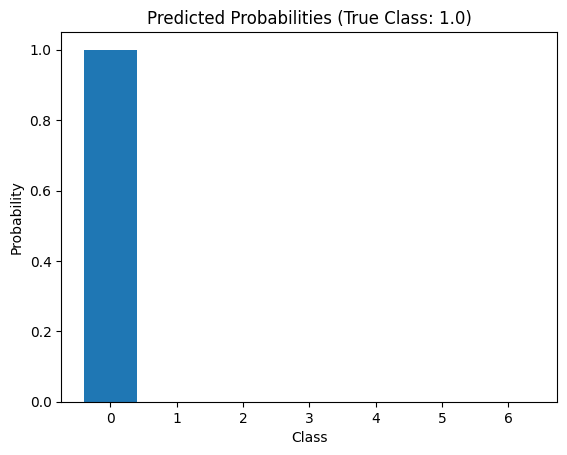

In [84]:
def find_misclassification(model, loader):
    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            for i, (pred, true) in enumerate(zip(predicted, labels)):
                if pred != true:
                    return data[i], outputs[i], true
    return None, None, None

data_sample, output_probs, true_label = find_misclassification(model, test_loader)

if data_sample is not None:
    classes = list(range(len(output_probs)))
    plt.bar(classes, output_probs.cpu().numpy())
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title(f"Predicted Probabilities (True Class: {true_label.item()})")
    plt.show()
else:
    print("No misclassification found in the provided test_loader.")

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


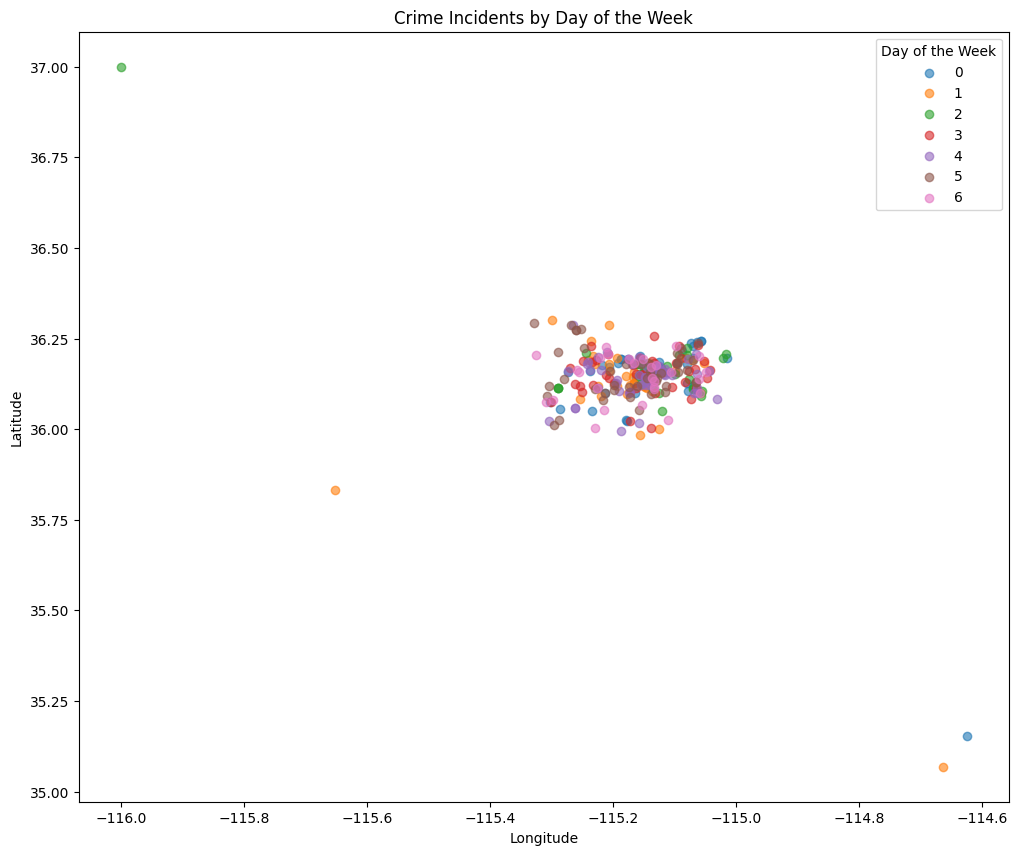

In [97]:
import matplotlib.pyplot as plt
import datetime

plt.figure(figsize=(12, 10))
for day in df['DayOfWeek'].unique():
    subset = df[df['DayOfWeek'] == day]
    plt.scatter(subset['X'], subset['Y'], label=day, alpha=0.6)

plt.legend(title="Day of the Week")
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

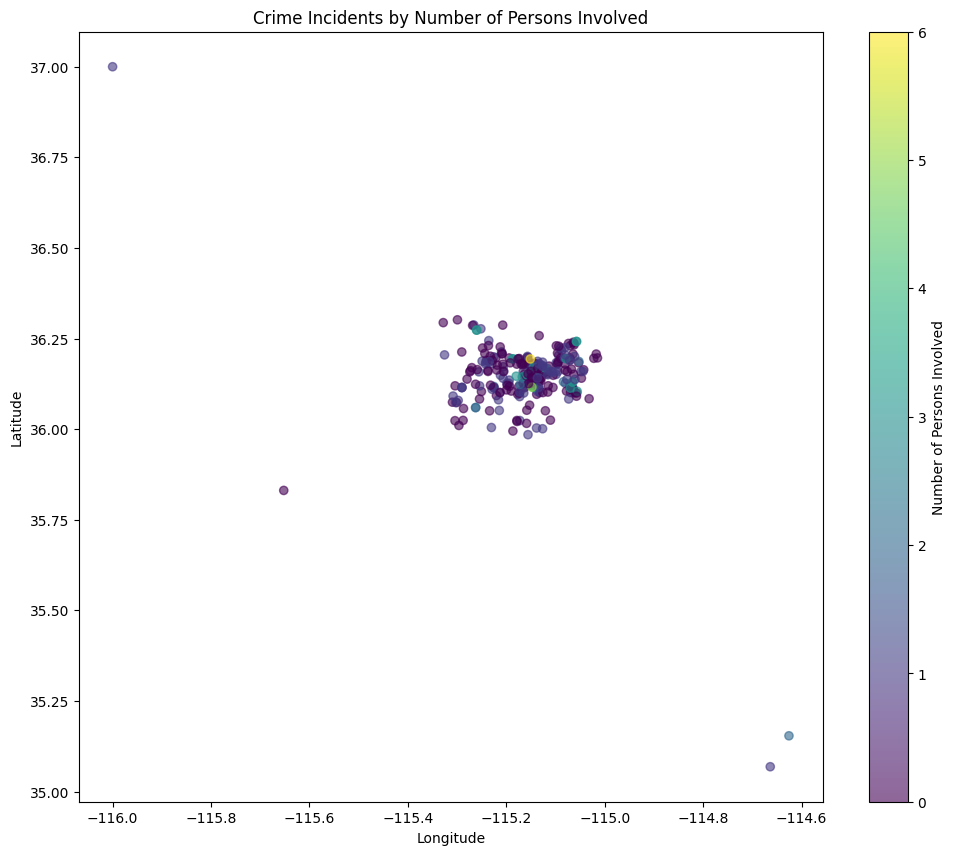

In [98]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Number of Persons Involved')
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [109]:
df = pd.read_csv('LVMPD-Stats.csv')
df['ReportedOn'] = pd.to_datetime(df['ReportedOn'])

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()

day_counts = df['DayOfWeek'].value_counts()

sorted_day_counts = day_counts.sort_values(ascending=False)

sorted_day_counts

Sunday       51
Saturday     44
Monday       43
Friday       40
Thursday     37
Tuesday      32
Wednesday    28
Name: DayOfWeek, dtype: int64

The most frequent day is Sunday, followed by Saturday then Monday